In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr

In [10]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")

disp_data = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]
inv_distance = 1/distance
df_d['admin1'] = df_d['admin1'].str.replace('_',' ')

v= disp_data["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]
for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i])) 
disp_data.insert(loc=3, column='date_timestamp', value=q)
disp_data = disp_data.sort_values("date_timestamp")
disp_data['Month End'] = pd.to_datetime(disp_data['Month End'], dayfirst=True)

aggregated_data = disp_data.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])
disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

disp_matxs = disp_data.pivot_table(index=['time','Previous (Departure) Region'], columns='Current (Arrival) Region', values='Number of Individuals', aggfunc='sum')
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

In [12]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
vac_lag = ['PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5']
lag_str = ['PA', 'PA_{lag1}', 'PA_{lag2}', 'PA_{lag3}', 'PA_{lag4}', 'PA_{lag5}']

/tmp/ipykernel_20089/1535912814.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


Scatter plot 

$$
Disp_{ji} = f(\frac{PA_{lag2, i}}{dist^2_{ji}})
$$


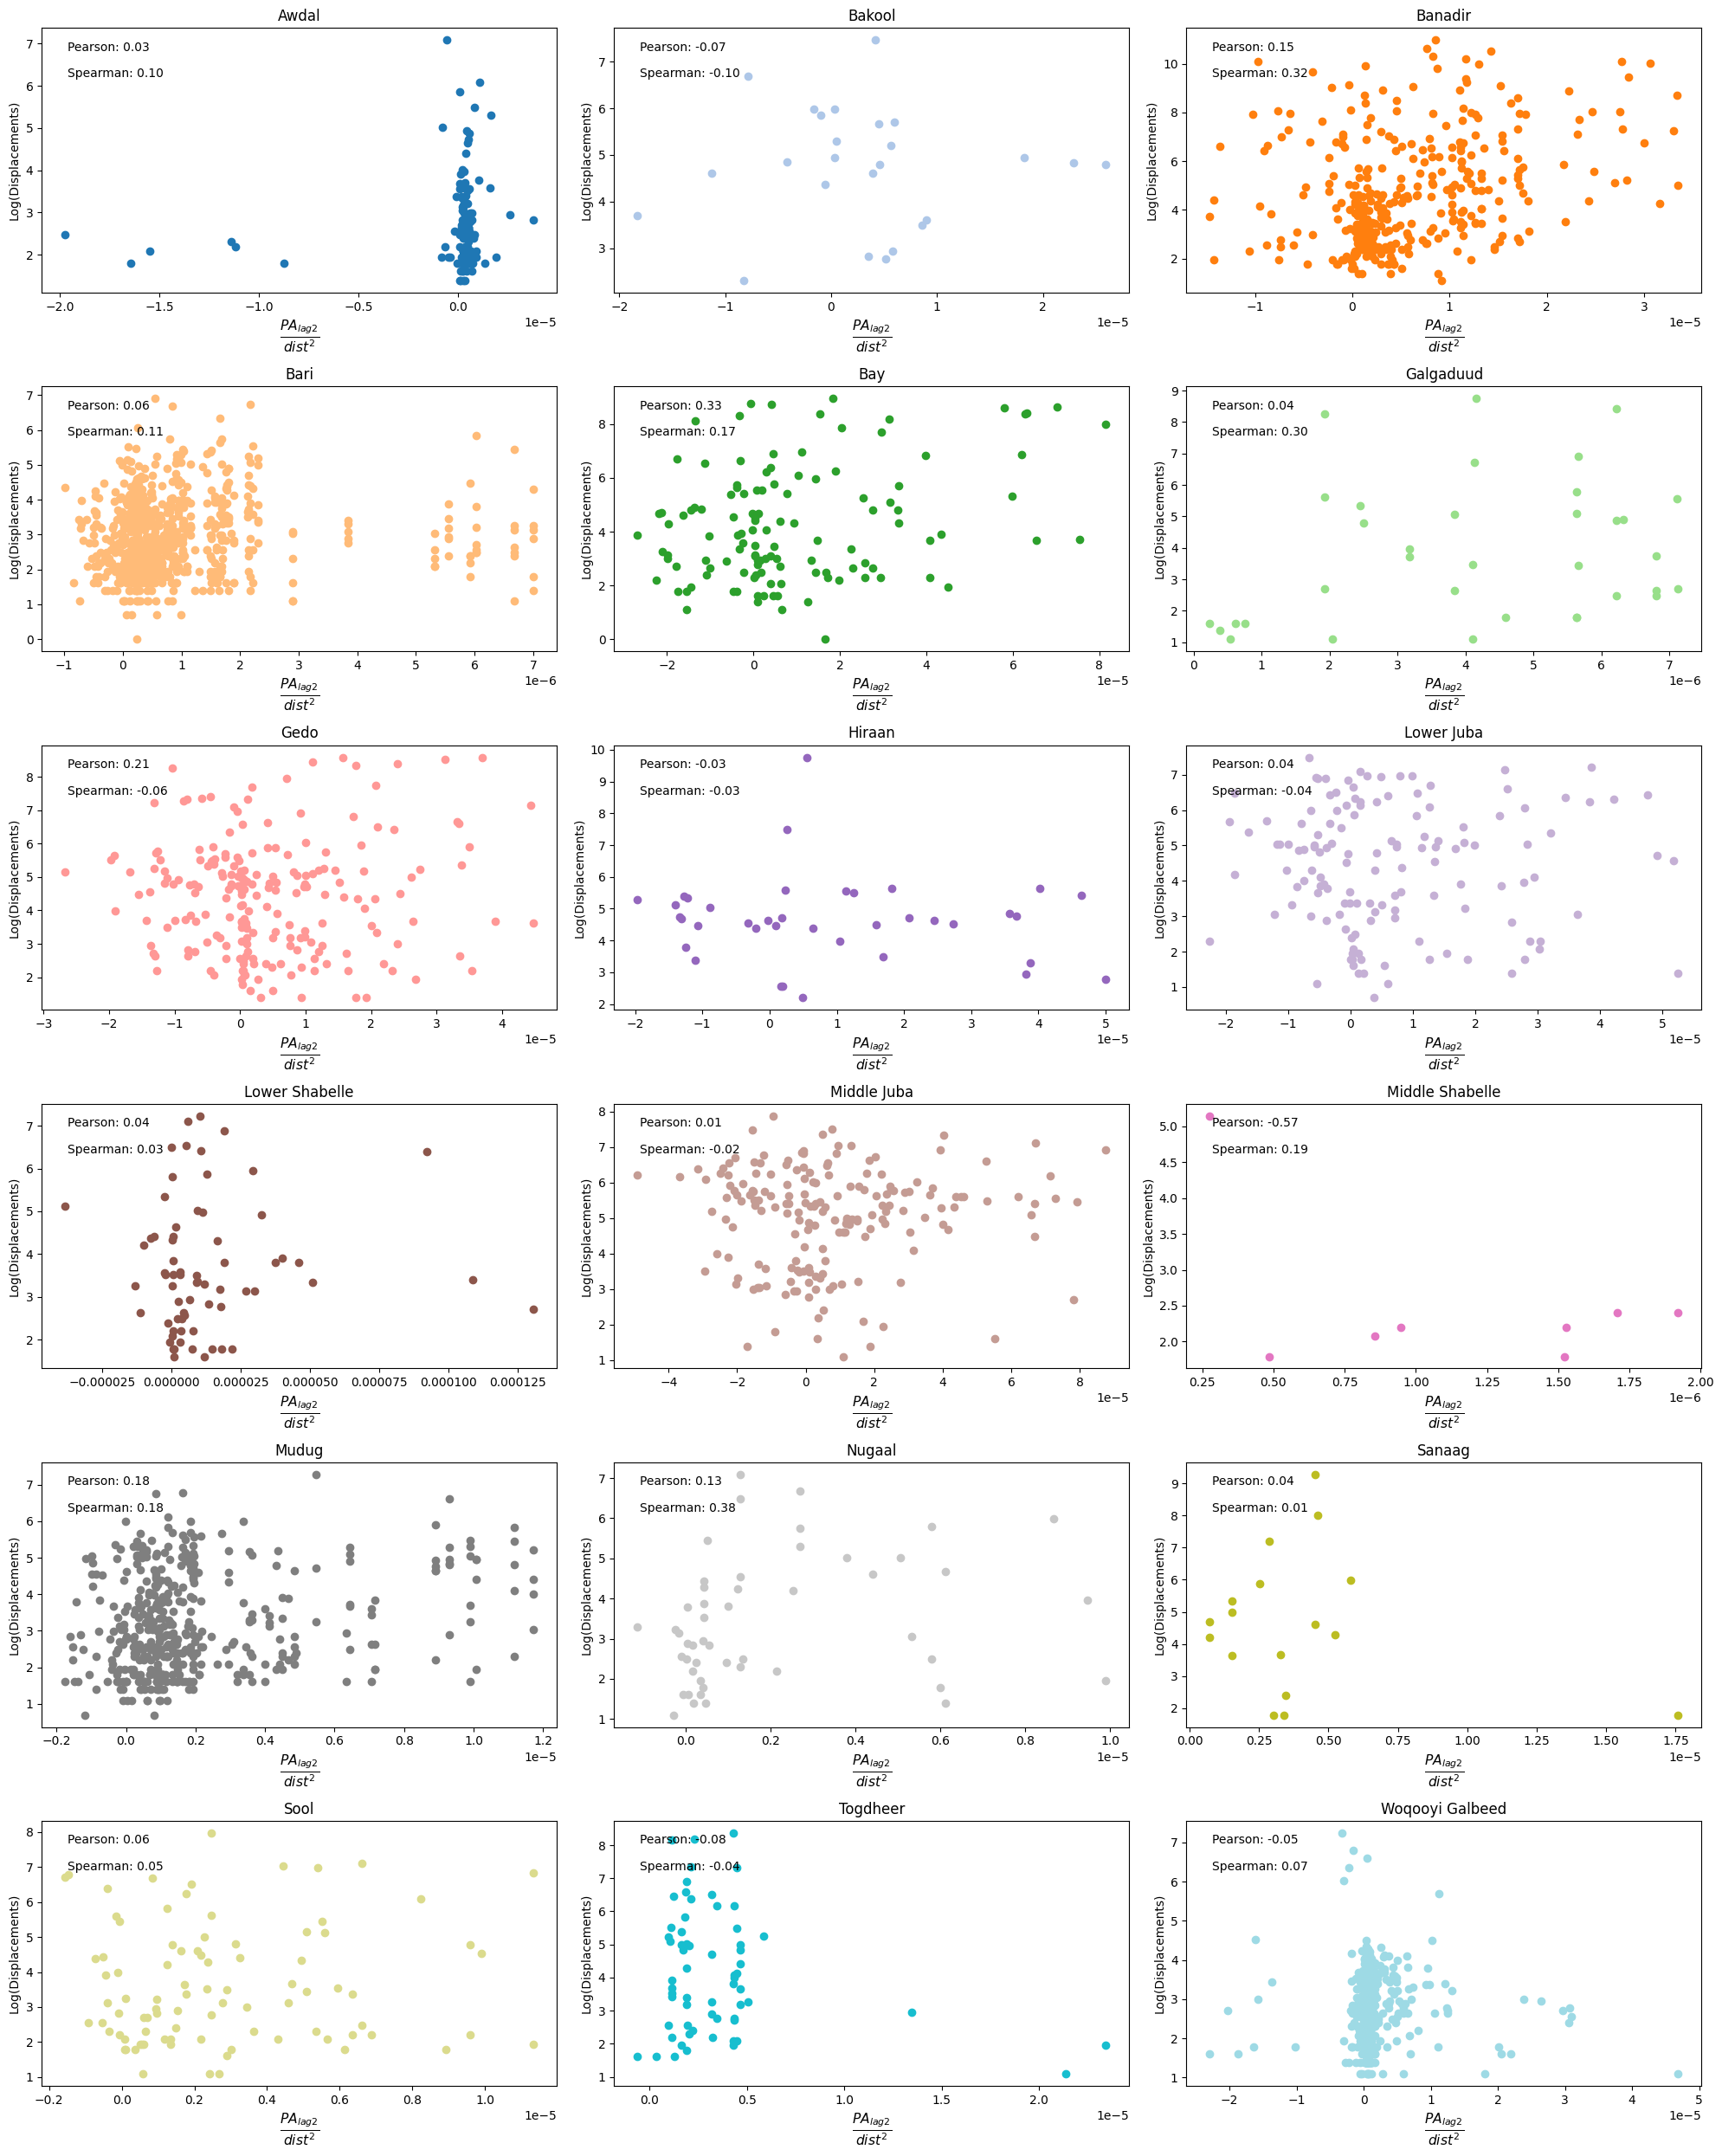

In [13]:
fig, axs = plt.subplots(6, 3, figsize=(20, 25))  

for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['PA_lag2'] = df_m_y['PA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            color = cmap(region_codes[regions == j][0])
            axs[row, col].scatter(disp_reg['PA_lag2']*disp_reg['inv_dist']**2, np.log(disp_reg[j]), color=color)
        
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['inv_dist']*df_j['PA_lag2'])]
    df_j = df_j[df_j['inv_dist']*df_j['inv_dist']*df_j['PA_lag2'] != np.nan]

    
    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['PA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['PA_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan

    axs[row, col].set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist^2}}$', fontsize=16)
    axs[row, col].set_ylabel('Log(Displacements)')
    axs[row, col].set_title(j)
    axs[row, col].text(0.05, 0.95, f"Pearson: {corr_pearson:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    axs[row, col].text(0.05, 0.85, f"Spearman: {corr_spearman:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    
plt.tight_layout()
plt.show()

Jointplot 

$$
Log(Disp_{ji}) = f(\frac{PA_{lag2, i}}{dist_{ji}})
$$

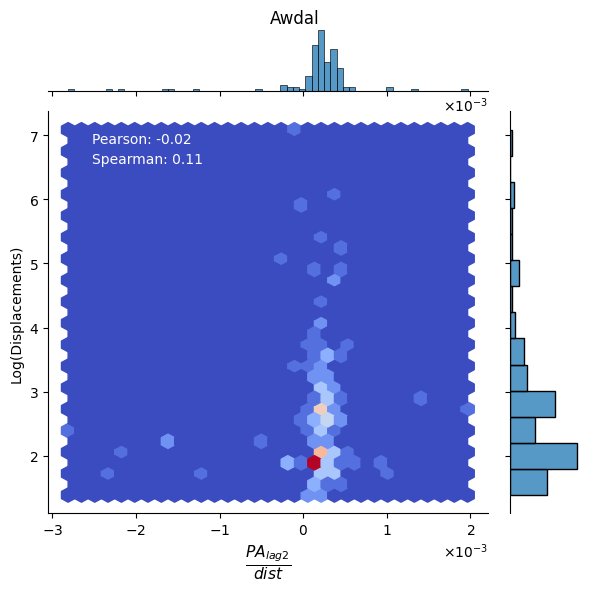

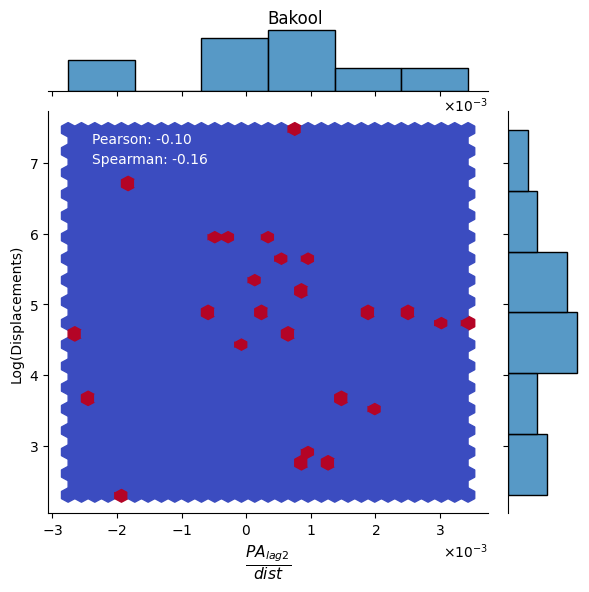

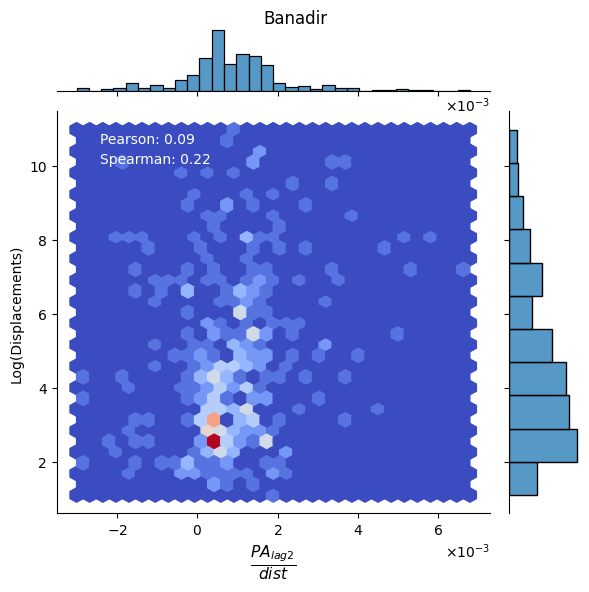

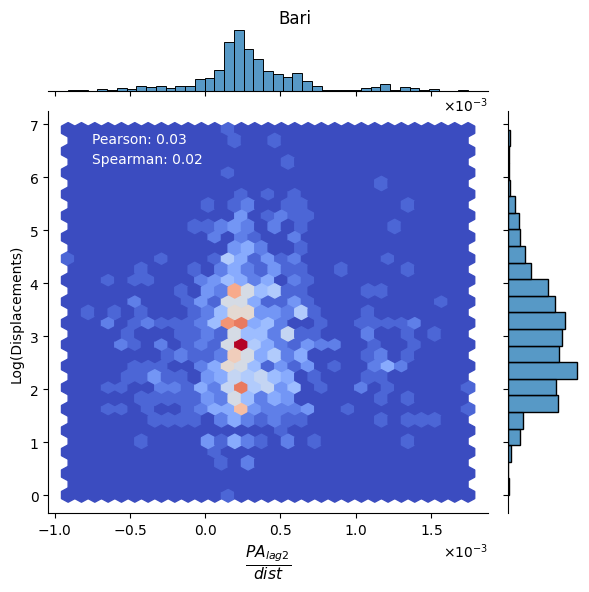

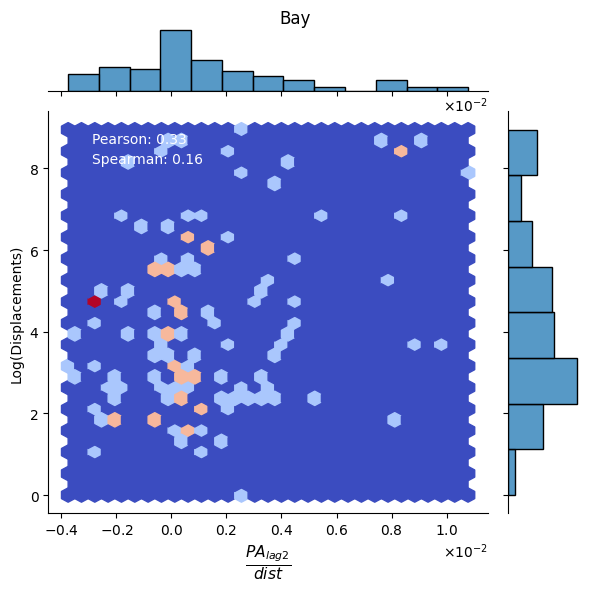

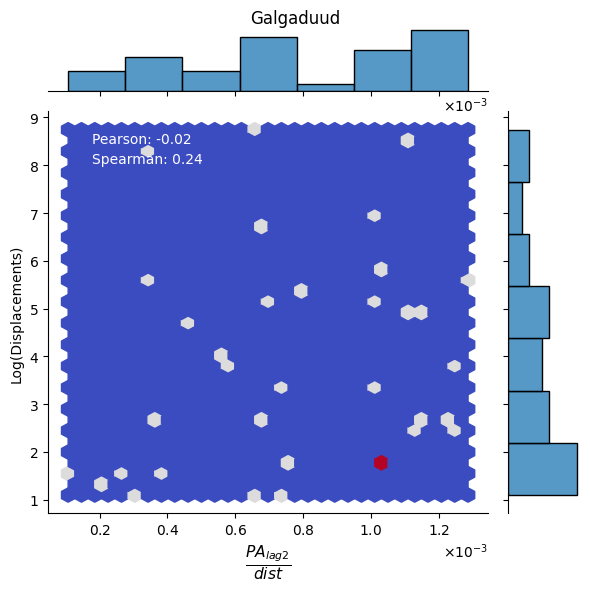

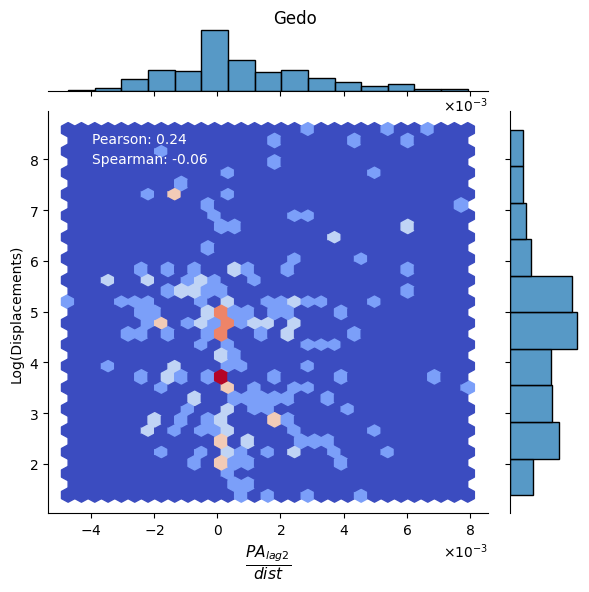

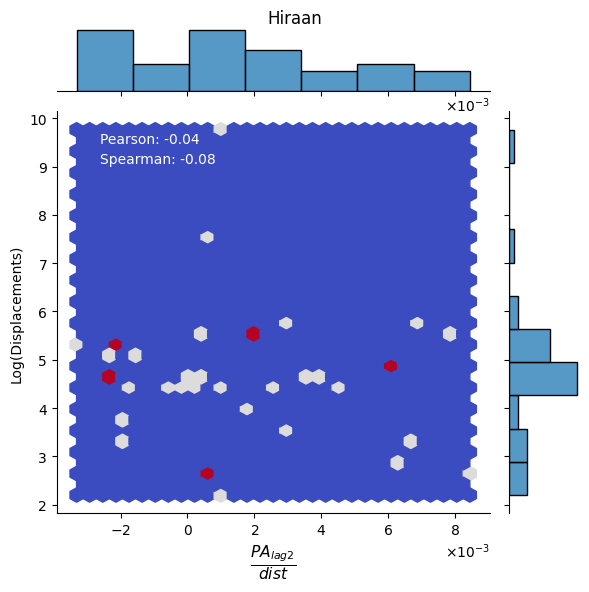

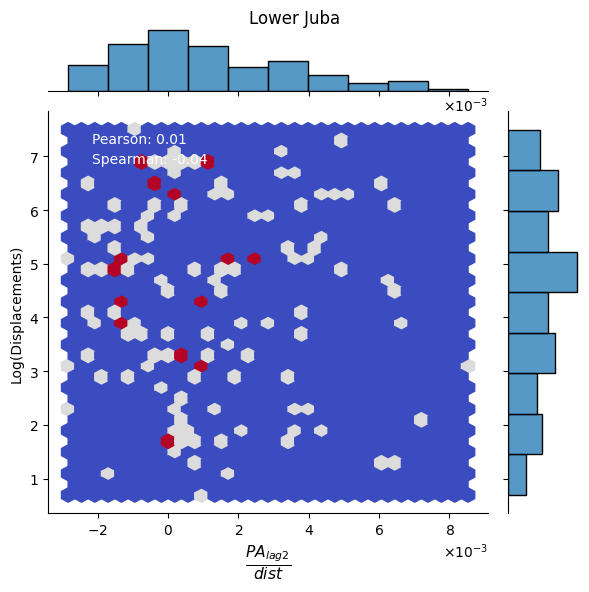

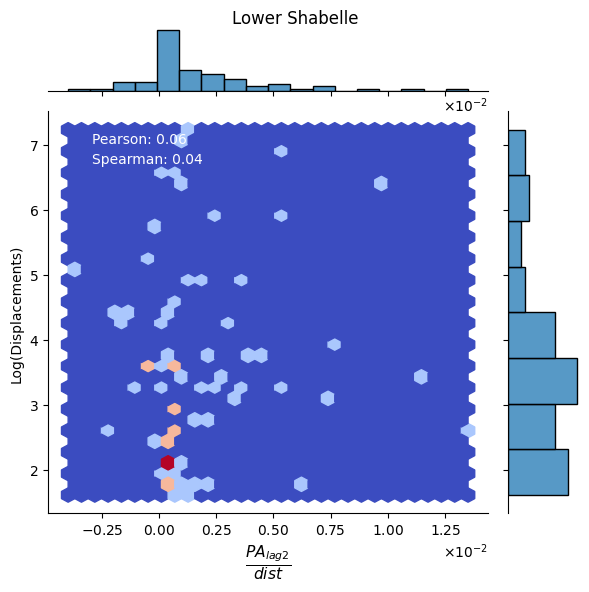

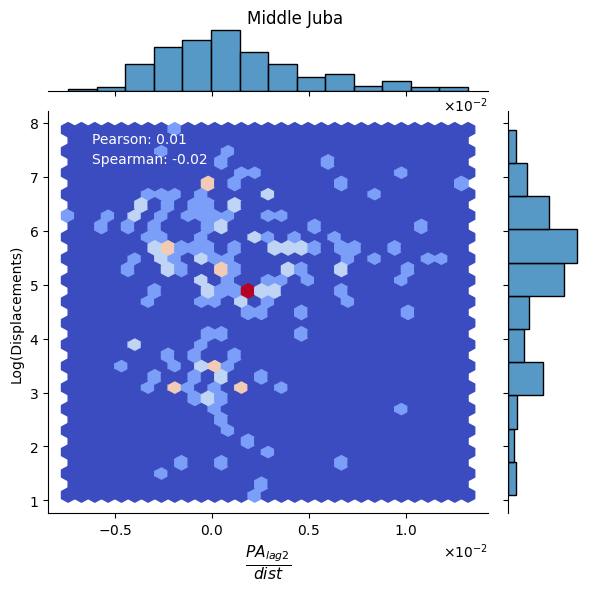

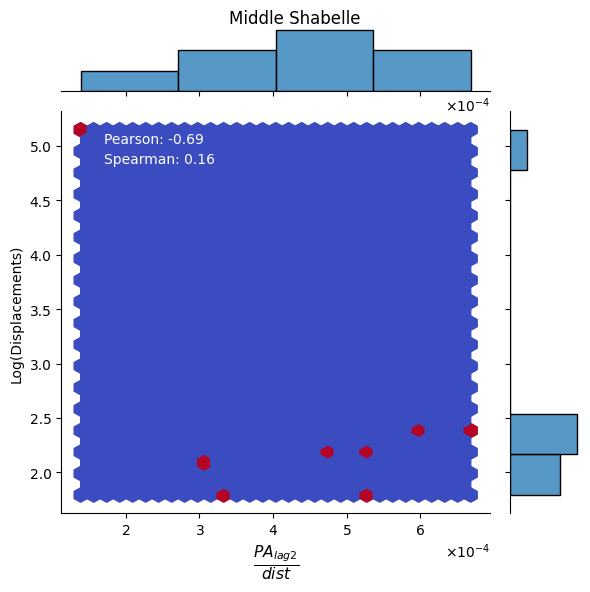

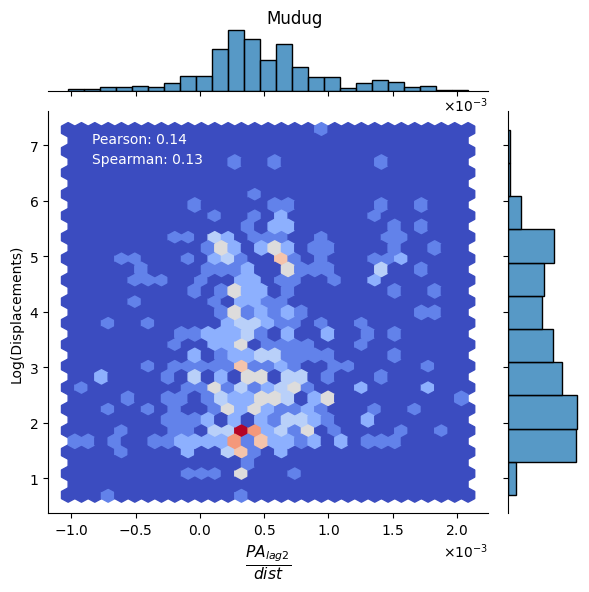

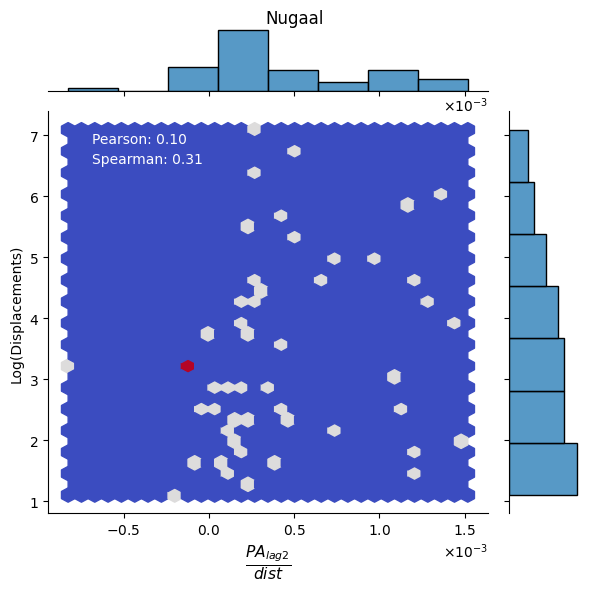

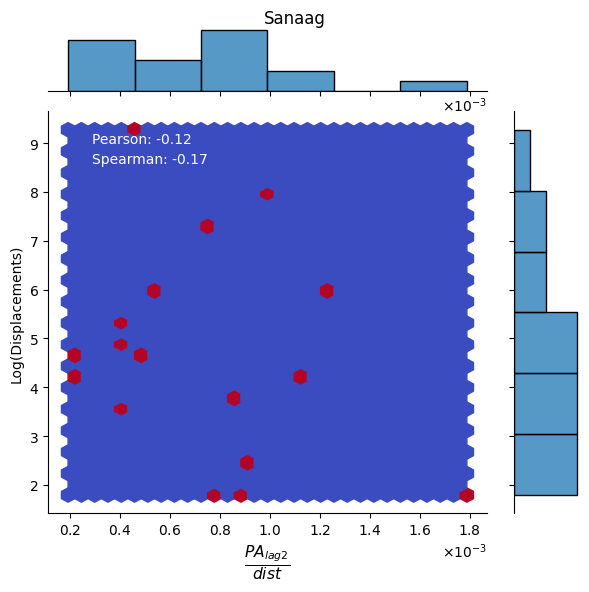

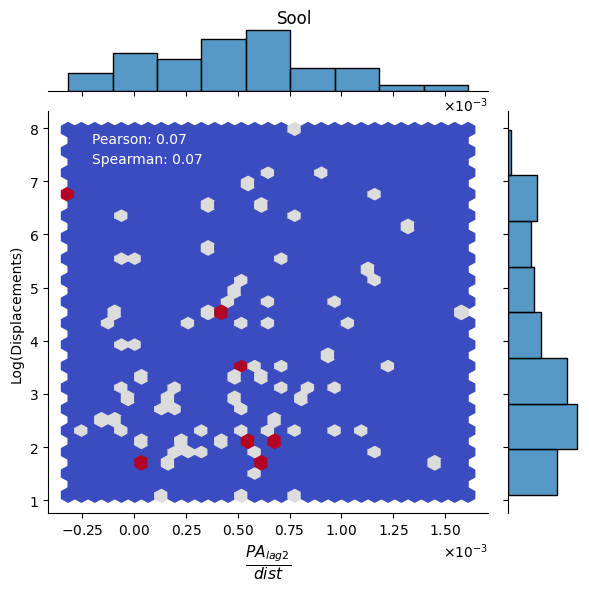

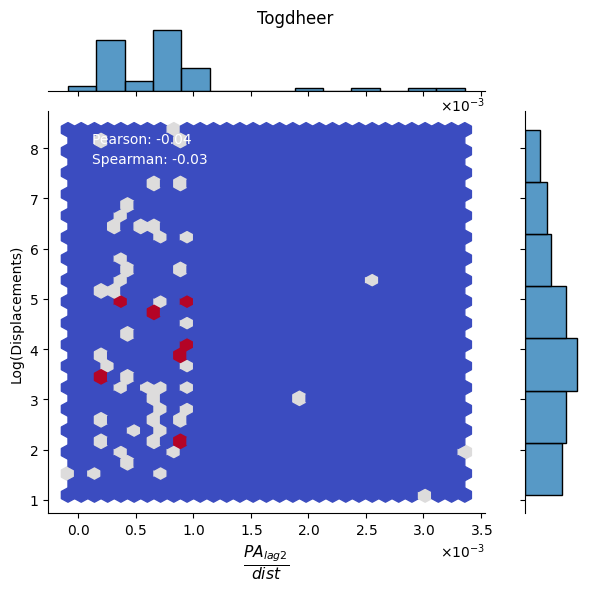

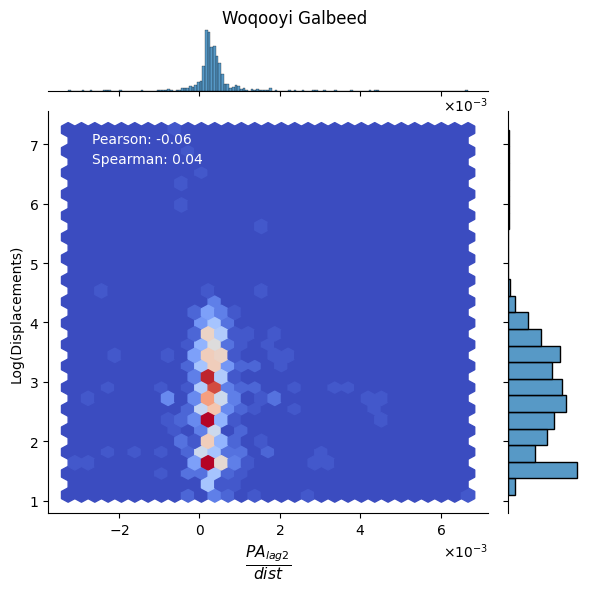

In [14]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['PA_lag2'] = df_m_y['PA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['PA_lag2'])]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['inv_dist']*df_j['PA_lag2'], df_j[j])
        corr_spearman, _ = spearmanr(df_j['inv_dist']*df_j['PA_lag2'], df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j['PA_lag2']*df_j['inv_dist']

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)
    
plt.show()

Jointplot 

$$
Log(Disp_{ji}) = f(\frac{PA_i}{dist^2_{ji}})
$$

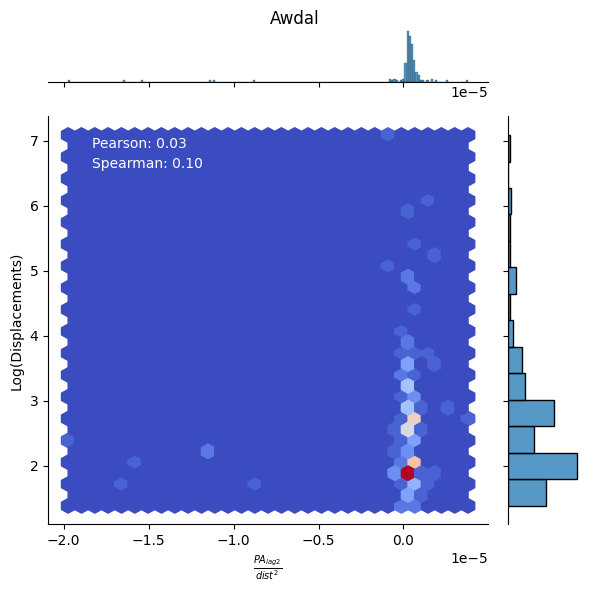

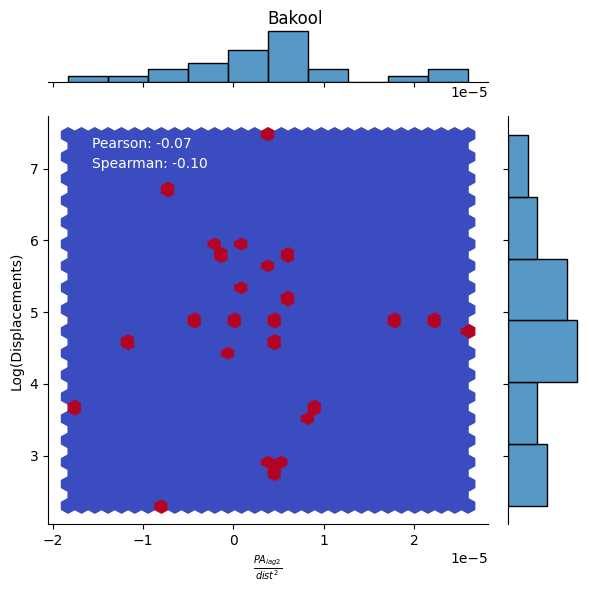

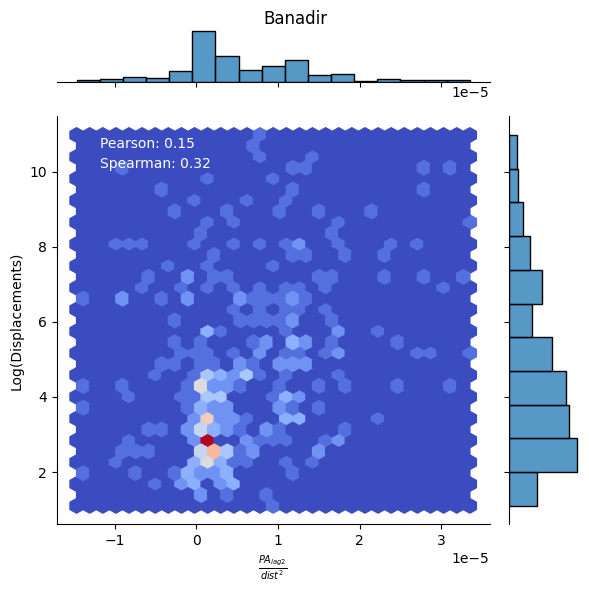

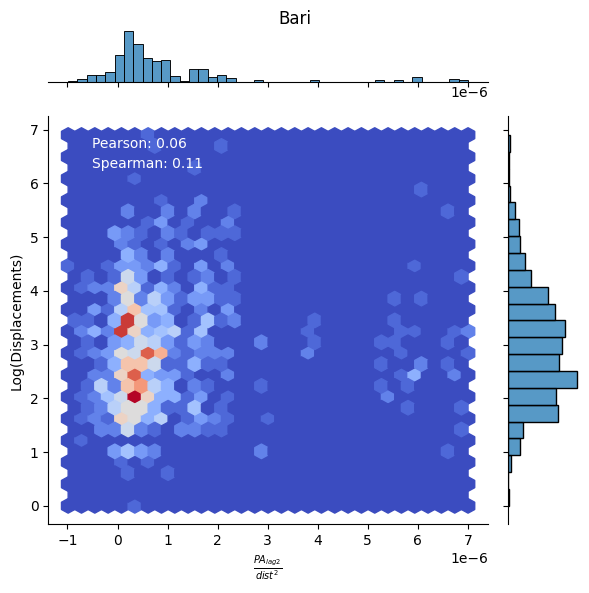

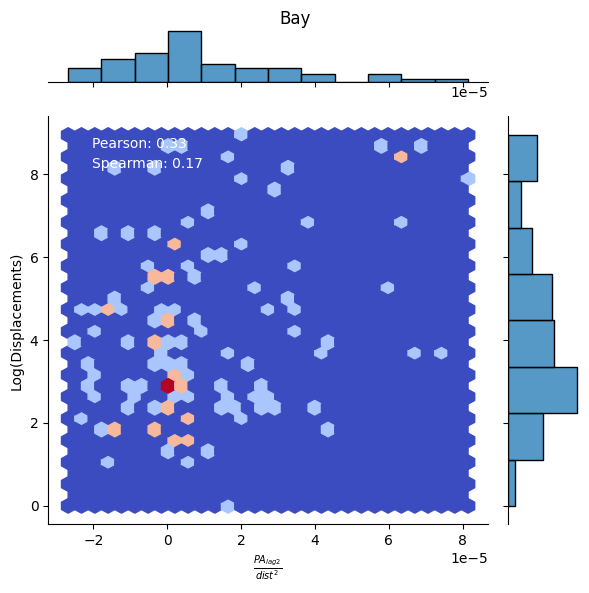

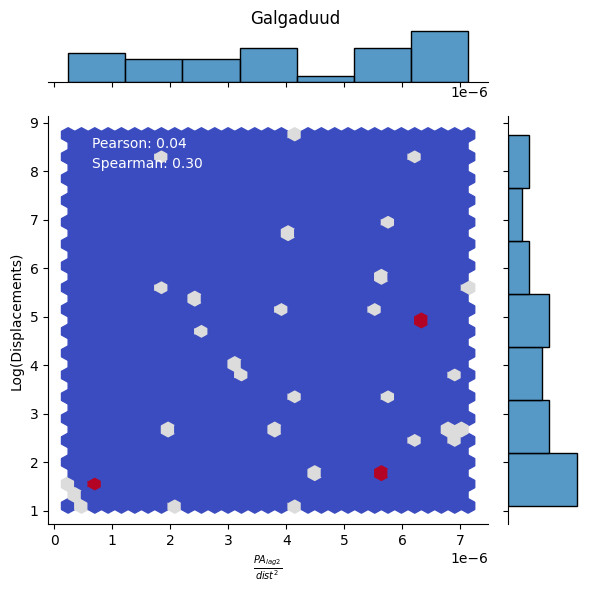

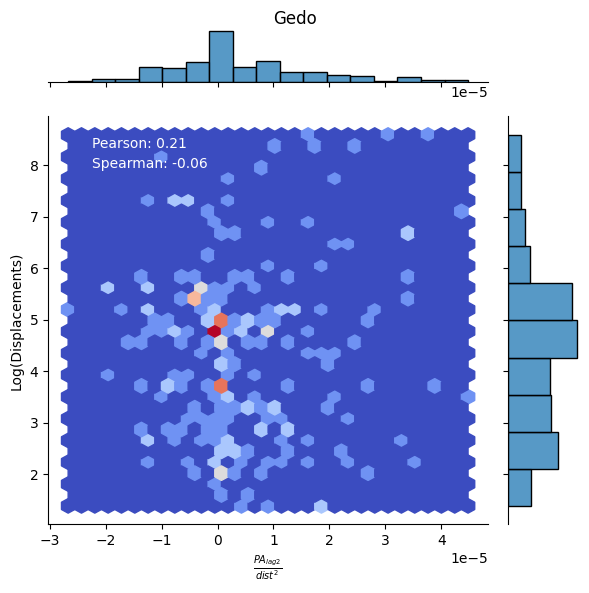

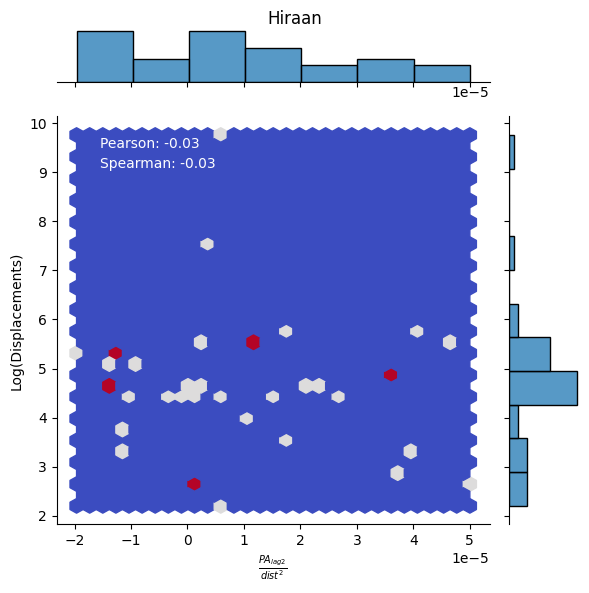

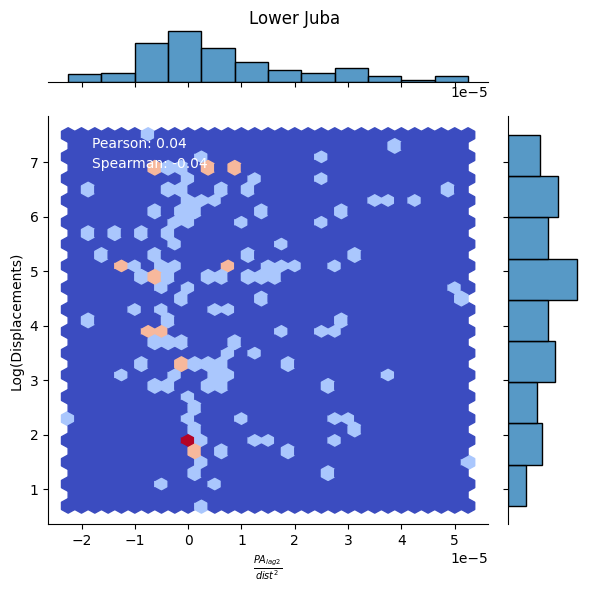

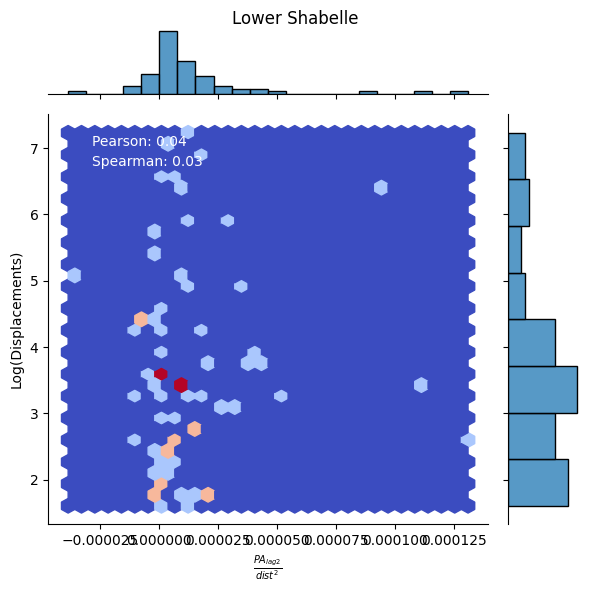

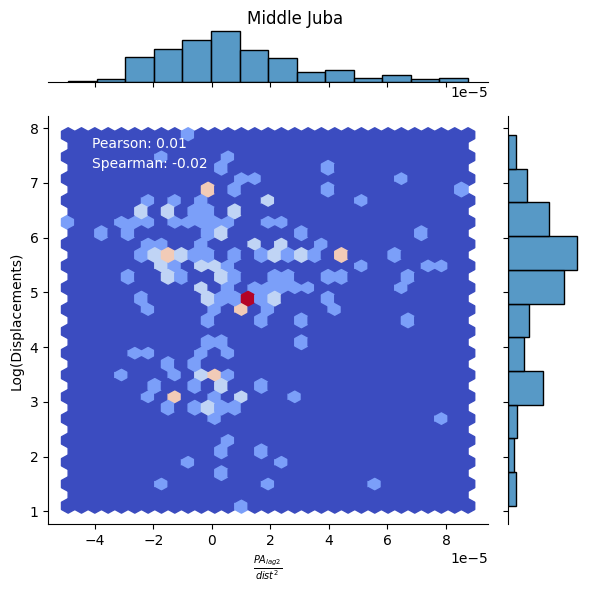

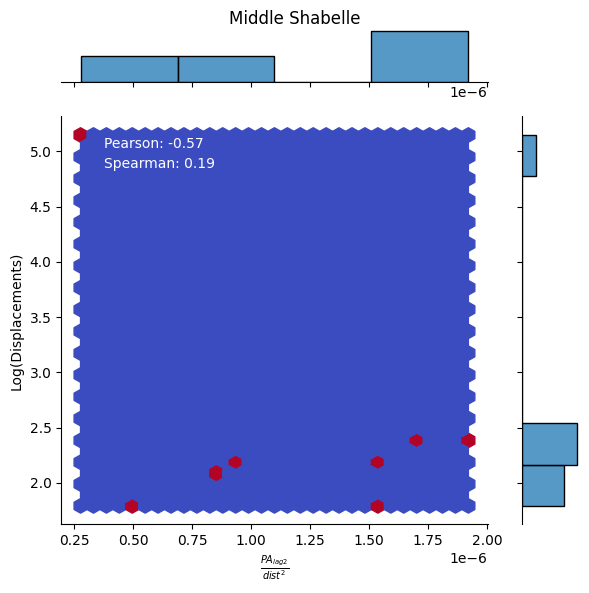

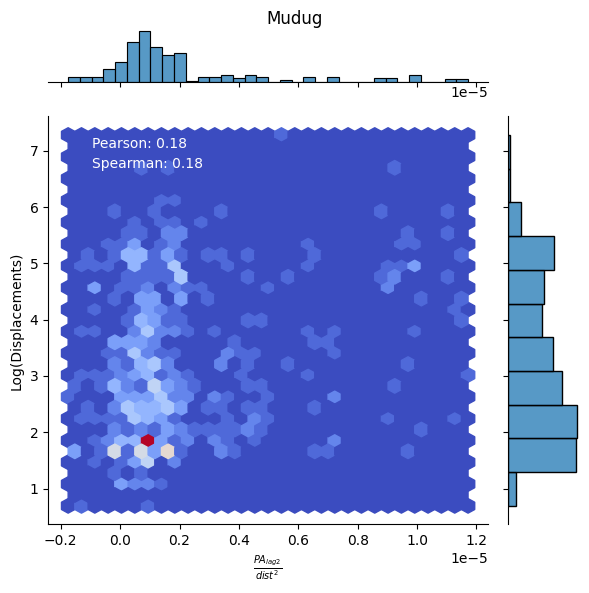

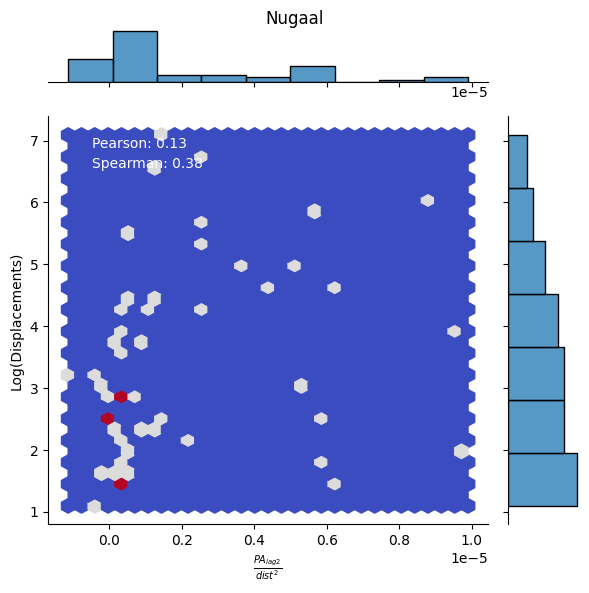

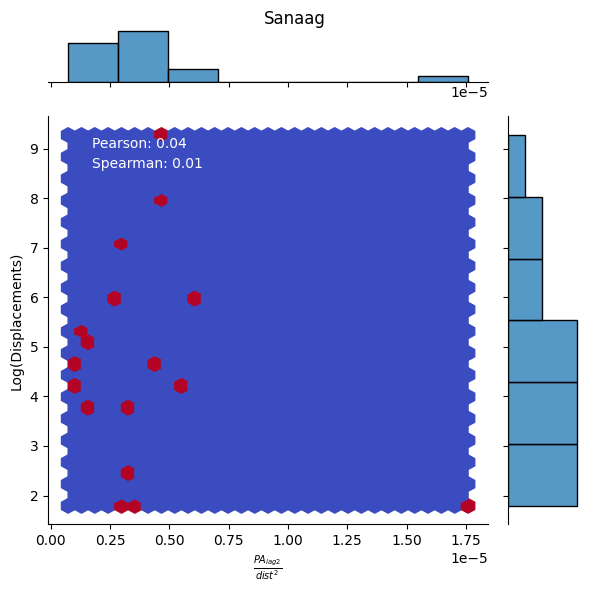

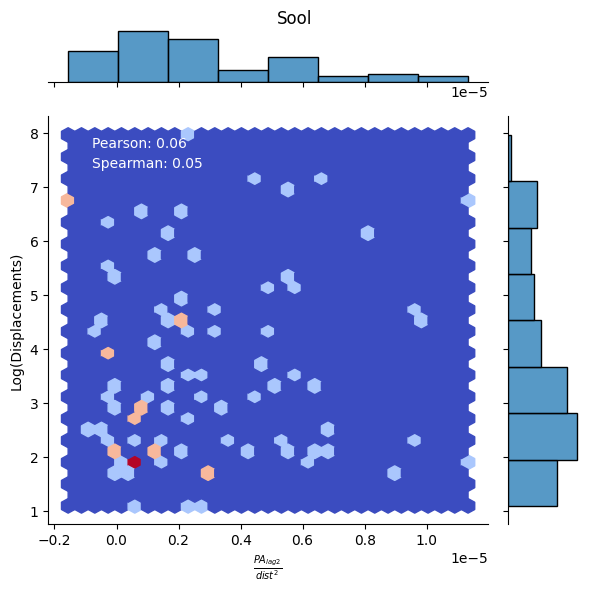

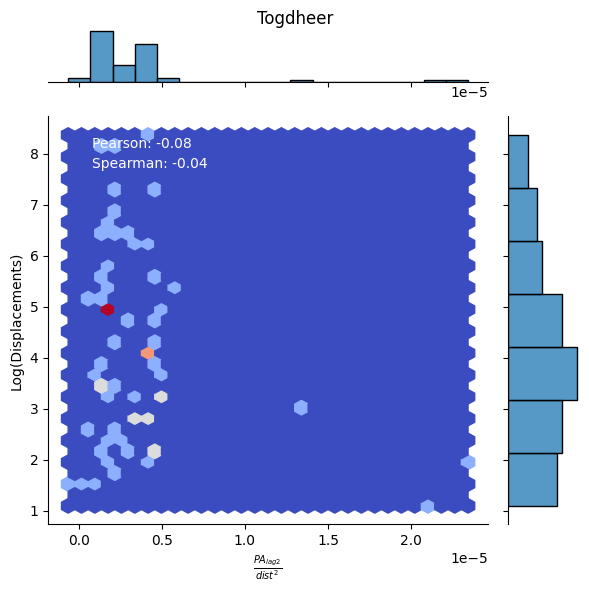

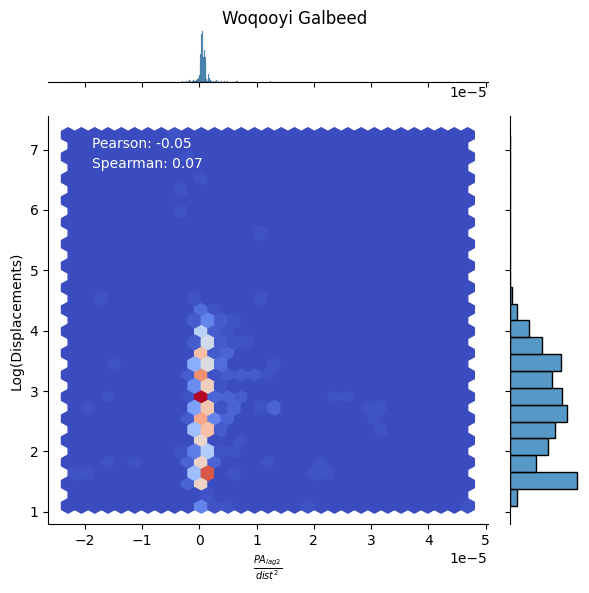

In [15]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['PA_lag2'] = df_m_y['PA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['PA_lag2']*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['PA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['PA_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j['PA_lag2']*df_j['inv_dist']**2

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist^2}}$')
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')

plt.show()

Heatmap Pearson and spearman coefficient

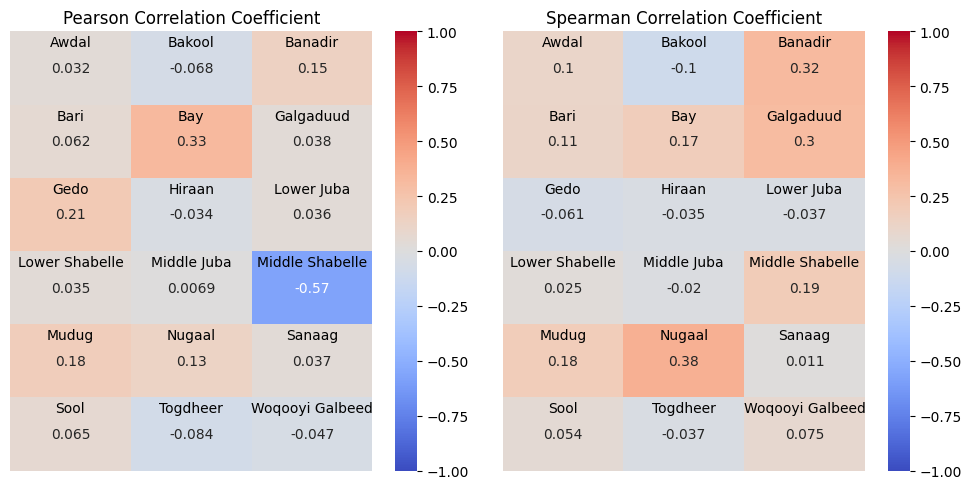

In [16]:
vec_corr_pearson = []
vec_corr_spearman = []

disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

for j in regions:
    disp_reg_list = []
    
    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            color = cmap(region_codes[regions == j][0])
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['PA_lag2'] = df_m_y['PA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]

            disp_reg_list.append(disp_reg)

    df_j = pd.concat(disp_reg_list, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['PA_lag2'])]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['PA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['PA_lag2']*df_j['inv_dist']**2, df_j[j])

        vec_corr_pearson.append(corr_pearson)
        vec_corr_spearman.append(corr_spearman)
    else:
        vec_corr_pearson.append(np.nan)
        vec_corr_spearman.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 3)
vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(vec_corr_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title('Pearson Correlation Coefficient')

sns.heatmap(vec_corr_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title('Spearman Correlation Coefficient')

for i, j in enumerate(regions):
    row = i // 3  # row index 
    col = i % 3   # column index 
    ax1.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)
    ax2.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

Heatmap Pearson and Spearman (lags and regions)

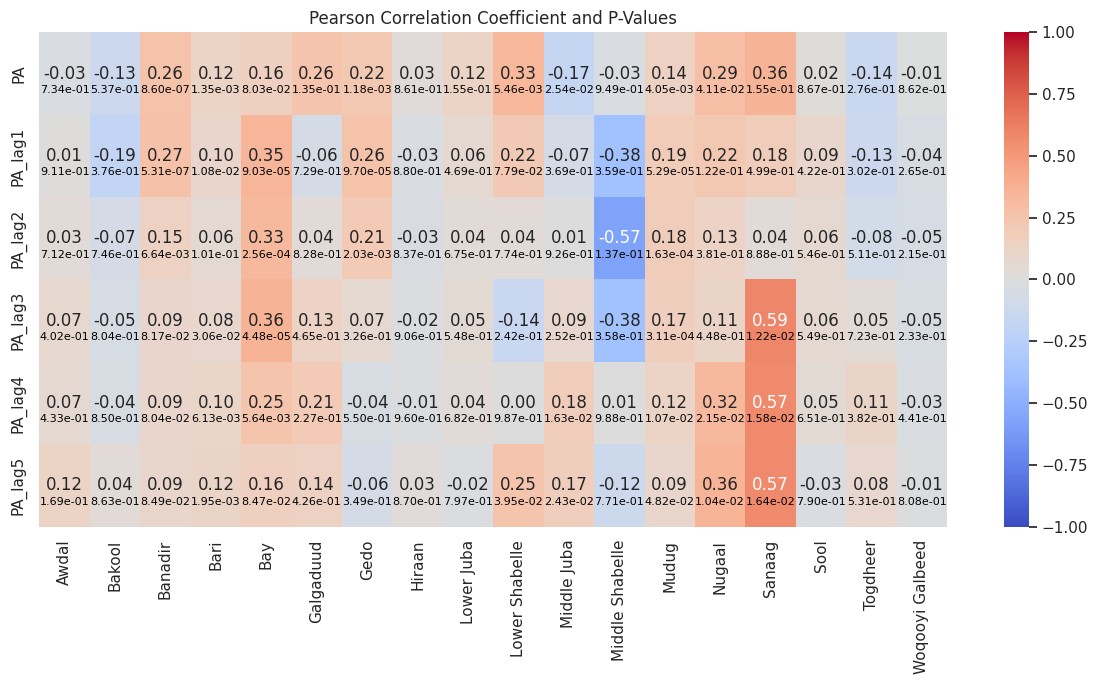

In [17]:
# Pearson coefficient heatmap

vec_corr_pearson = []
vec_p_values = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5']

for PA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
                disp_reg['PA_lag_n'] = df_m_y[PA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['PA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['PA_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_corr_pearson.append(corr_pearson)
            vec_p_values.append(p_value)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)
vec_p_values = np.array(vec_p_values).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

# Add p-values to the heatmap
for i in range(vec_p_values.shape[0]):
    for j in range(vec_p_values.shape[1]):
        if not np.isnan(vec_p_values[i, j]):
            ax.text(j + 0.5, i + 0.7, f'{vec_p_values[i, j]:.2e}', ha='center', va='center', fontsize=8, color='black')

plt.title('Pearson Correlation Coefficient and P-Values')
plt.tight_layout()
plt.show()

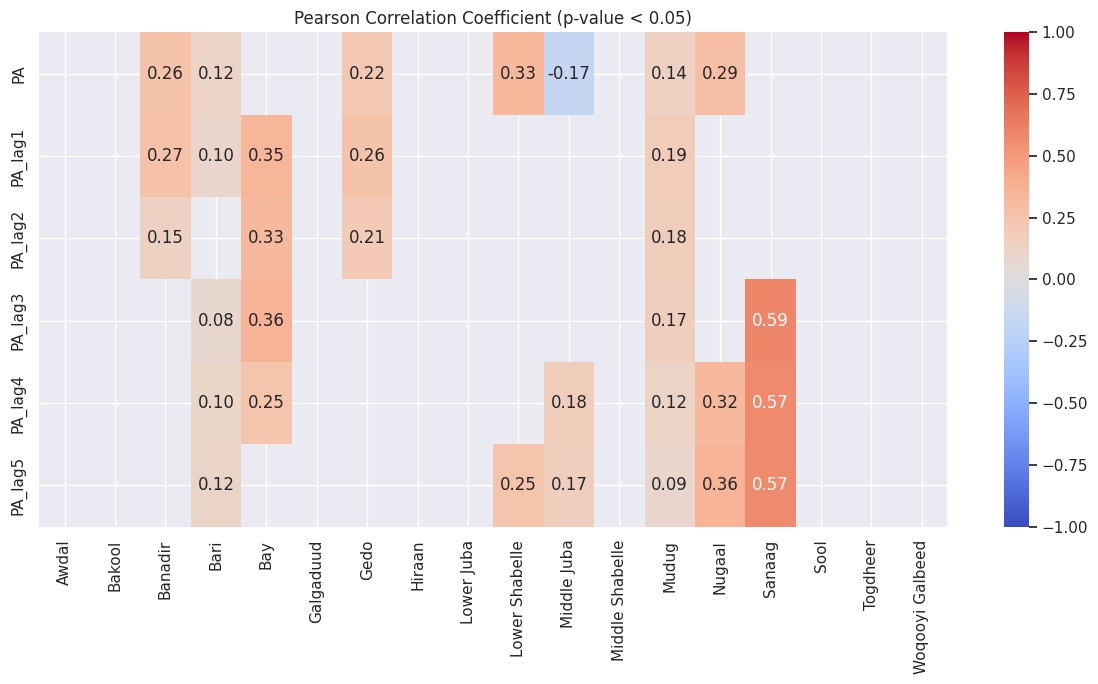

In [18]:
vec_corr_pearson = []
vec_p_values = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5']

for PA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
                disp_reg['PA_lag_n'] = df_m_y[PA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['PA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['PA_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

In [19]:
disp_reg

,time,Previous (Departure) Region,Woqooyi Galbeed,inv_dist,PA_lag_n
15,2022-12-31,Sool,13,0.002925,0.068439
16,2022-12-31,Togdheer,62,0.006971,0.131334
17,2022-12-31,Woqooyi Galbeed,61,inf,0.439765


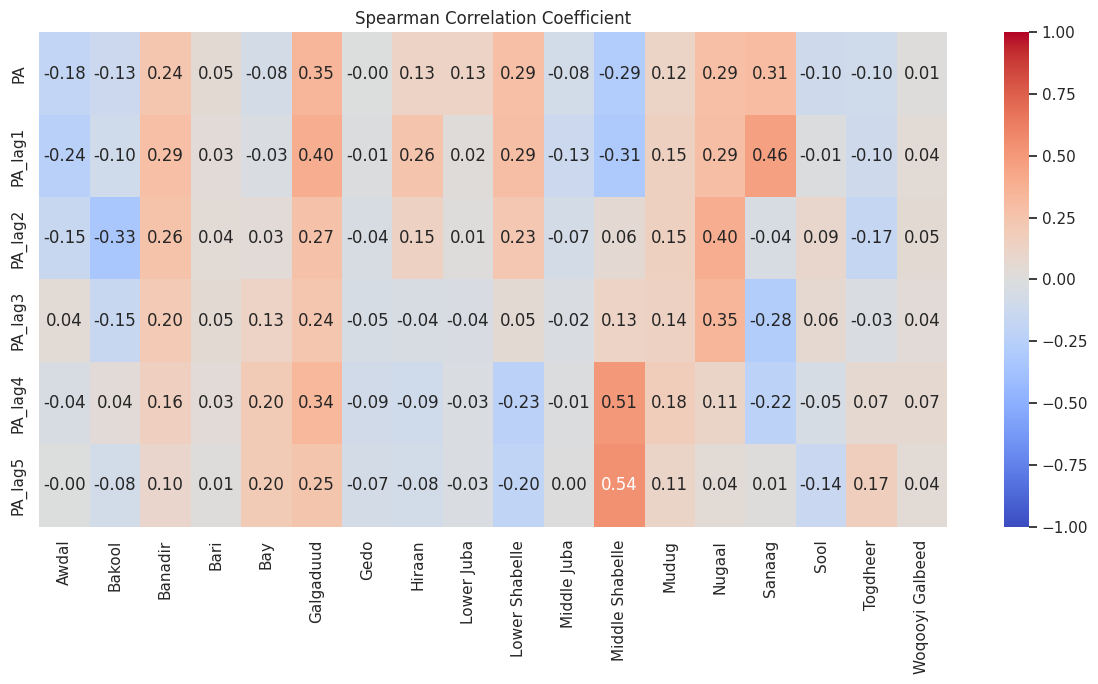

In [20]:
# Spearman coefficient heatmap

vec_corr_spearman = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5']

for PA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(1, 13):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[18*(month-1):18*(month +17)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
                disp_reg['PA_lag_n'] = df_m_y[PA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['PA_lag_n']*df_j['inv_dist']**2)]

        if len(df_j[j]) >= 2:
            corr_spearman, _ = spearmanr(df_j['inv_dist']*df_j['PA_lag_n'], df_j[j])
            vec_corr_spearman.append(corr_spearman)
        else:
            vec_corr_spearman.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)
#increase cell size
sns.set(rc={'figure.figsize':(12,7)})
sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)
plt.title('Spearman Correlation Coefficient')
plt.tight_layout()
plt.show()

Jointplot for Banadir region with different lags

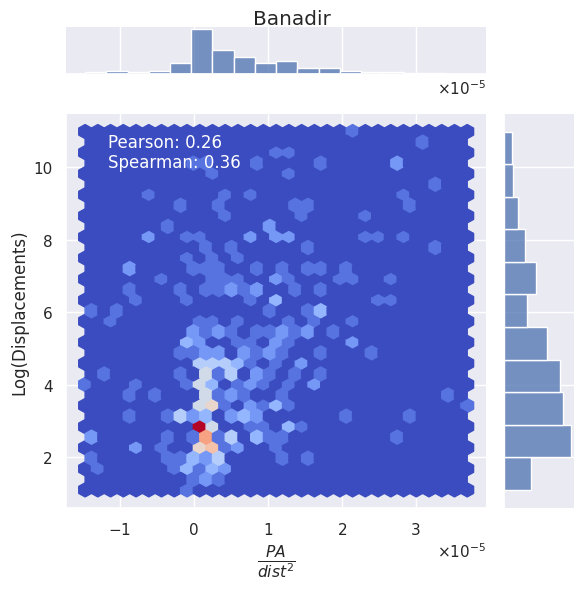

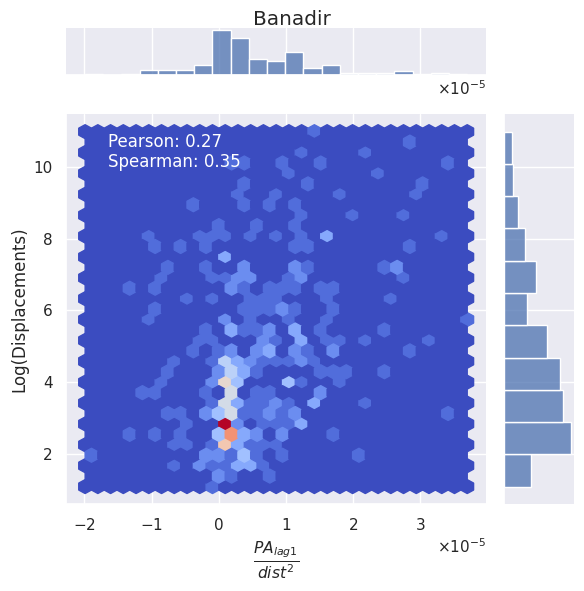

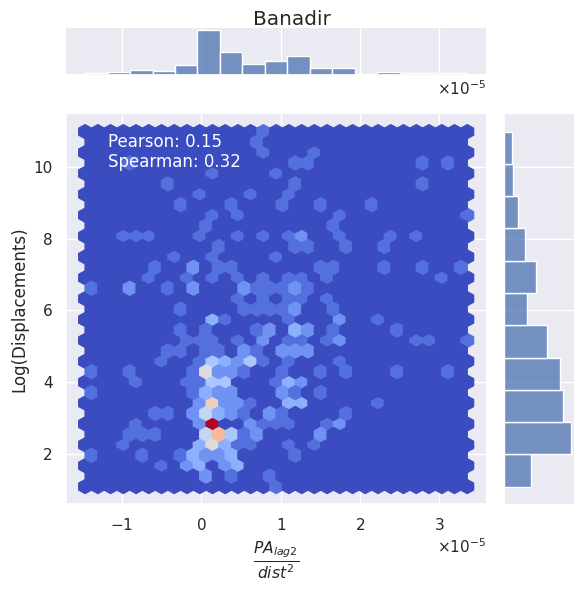

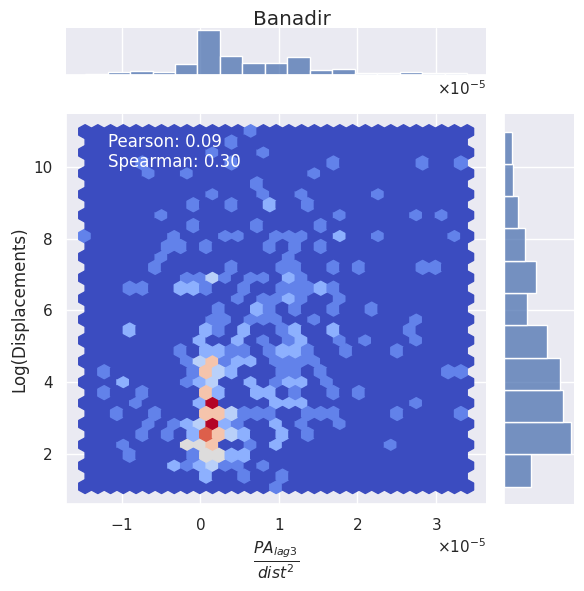

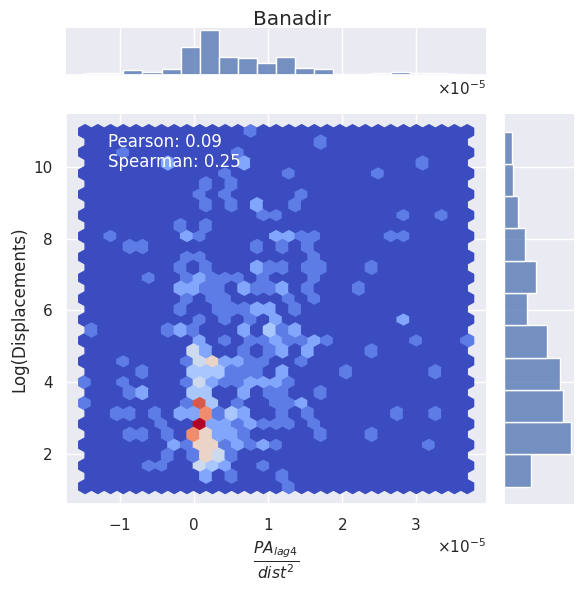

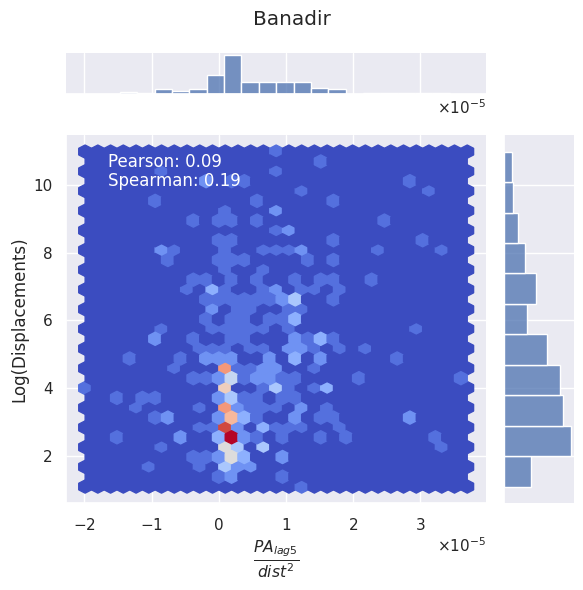

In [21]:
j = 'Banadir'
color = cmap(region_codes[regions == j][0])

for i, lag in enumerate(vac_lag):

    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg[lag] = df_m_y[lag]
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j[lag]*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j[lag]*df_j['inv_dist']**2

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.fig.set_size_inches(6, 6)
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[i]}}}{{dist^2}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


    #pearson
    #spearman

    #heatmp con regioni per righe e lag per colonne con il coeff di correlazione, per vedere se colonne sono piu significative
    #prova anche con PA e DL
    #diverse funz di distanza
    #per tutte le regioni distinte
    #e con tutte le regioni insieme
    #anzichè scatter heatmap dei punti (vedi seaborn, slack) 
    #(colora i punti proporzionalmente alla PA della regione di arrivo)
    #

In [22]:
arrival = disp_data.groupby(['time','Current (Arrival) Region'])['Number of Individuals'].sum()
arrival

time        Current (Arrival) Region
2016-01-31  Awdal                        89
            Bakool                        0
            Banadir                       0
            Bari                         31
            Bay                         114
                                       ... 
2023-08-31  Nugaal                      500
            Sanaag                        0
            Sool                         54
            Togdheer                    266
            Woqooyi Galbeed              55
Name: Number of Individuals, Length: 1656, dtype: int64